### This notebook shows how to use recurrent neural network for multi-step forecast of power consumption.

In [1]:
import sys
import numpy as np
import pandas as pd

from datetime import timedelta as td
import dateutil.parser

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2 as reg_l2
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

print('Python version:', sys.version)
print("TensorFlow {}".format(tf.__version__))

Python version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
TensorFlow 2.3.0


# Load data

The dataset was taken from https://www.kaggle.com/robikscube/hourly-energy-consumption

In [2]:
# data for analysis
df = pd.read_csv('data/energy/EKPC_hourly.csv', parse_dates=['Datetime'])

# sort dataframe
df = df.sort_values(by='Datetime').reset_index(drop=True)

df.head()

,Datetime,EKPC_MW
0,2013-06-01 01:00:00,1166.0
1,2013-06-01 02:00:00,1098.0
2,2013-06-01 03:00:00,1036.0
3,2013-06-01 04:00:00,1023.0
4,2013-06-01 05:00:00,949.0


In [3]:
df.tail()

,Datetime,EKPC_MW
45329,2018-08-02 20:00:00,1815.0
45330,2018-08-02 21:00:00,1769.0
45331,2018-08-02 22:00:00,1756.0
45332,2018-08-02 23:00:00,1619.0
45333,2018-08-03 00:00:00,1448.0


# Explore data

In [4]:
print(df.shape) # shape
print()
print(df.info()) # general info
print()
df.isna().sum() # missing values

(45334, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
Datetime    45334 non-null datetime64[ns]
EKPC_MW     45334 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.4 KB
None



Datetime    0
EKPC_MW     0
dtype: int64

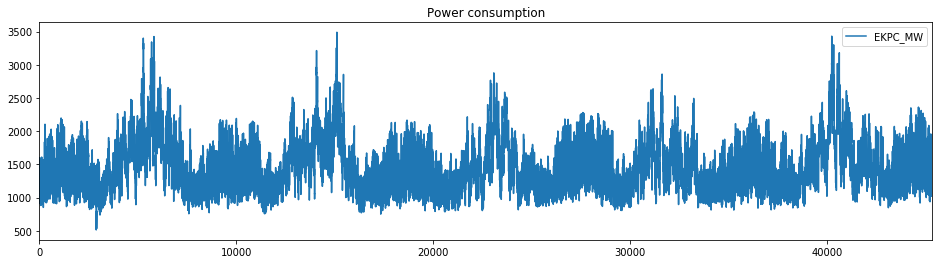

In [5]:
# Data visualization
df['EKPC_MW'].plot(figsize=(16,4),legend=True)
plt.title('Power consumption')
plt.show()

# Create pipeline

In [6]:
# Custom Transformer: Encode calendar data
class DatetimeProcessor(BaseEstimator, TransformerMixin):
    # Class Constructor 
    def __init__(self):
        pass
    
    # Return self nothing else to do here    
    def fit(self, X, y=None):
        return self 
    
    # Method that describes what we need this transformer to do
    def transform(self, X, y=None):
        return np.concatenate([X['Datetime'].apply(lambda x: x.month).values.reshape(-1,1), 
                               X['Datetime'].apply(lambda x: int(x.day/7)).values.reshape(-1,1),
                               X['Datetime'].apply(lambda x: x.weekday()).values.reshape(-1,1),
                               X['Datetime'].apply(lambda x: x.hour).values.reshape(-1,1)], axis=1)

# preprocessing pipeline
feature_transformer = Pipeline(steps=[('calendar', DatetimeProcessor()),
                                      ('onehot', OneHotEncoder(sparse=False))])

# transformer for scaling target variable
target_transformer = MinMaxScaler(feature_range=(0.1, 4.1))

# Split data

In [7]:
'''
Data is split as follows:
from 2013-06-01 to 2016-01-01 for training
from 2016-01-01 to 2017-01-01 for validation
from 2017-01-01 to 2018-08-03 for testing
'''

# panda data
df_train = df[df.Datetime < dateutil.parser.parse("2016-01-01")]
df_valid = df[(df.Datetime >= dateutil.parser.parse("2016-01-01")) & (df.Datetime < dateutil.parser.parse("2017-01-01"))]
df_test = df[df.Datetime >= dateutil.parser.parse("2017-01-01")]

# numpy data
X_train = feature_transformer.fit_transform( df_train )
y_train = target_transformer.fit_transform( df_train['EKPC_MW'].values.reshape(-1,1) )

X_valid = feature_transformer.transform(df_valid)
y_valid = target_transformer.transform(df_valid['EKPC_MW'].values.reshape(-1,1))

X_test = feature_transformer.transform(df_test)
y_test = target_transformer.transform(df_test['EKPC_MW'].values.reshape(-1,1))

# print shape of arrays
print('X_train = {} y_train = {}'.format(X_train.shape, y_train.shape))
print('X_valid = {} y_valid = {}'.format(X_valid.shape, y_valid.shape))
print('X_test = {} y_test = {}'.format(X_test.shape, y_test.shape))

X_train = (22654, 48) y_train = (22654, 1)
X_valid = (8784, 48) y_valid = (8784, 1)
X_test = (13896, 48) y_test = (13896, 1)


In [8]:
# organize data in a way suitable for tensorflow model
def get_data(x_vals, y_vals, T=24):

    x, y = [], []
    
    for i in range(1, y_vals.shape[0]-T):   
        x_ = x_vals[i,:].reshape(1, -1)
        y_ = y_vals[i-1].reshape(1, -1)
        f = np.concatenate((x_, y_), axis=1)        
        x.append(f)
        
        y.append(y_vals[i:i+T].reshape(-1, 1))
    
    return np.array(x), np.transpose(np.array(y), (1, 0, 2))

# get data sets in numpy arrays
x_train, y_train_np = get_data(X_train, y_train)
x_valid, y_valid_np = get_data(X_valid, y_valid)
x_test, y_test_np = get_data(X_test, y_test)

# print shape of array
print('x_train = {} y_train = {}'.format(x_train.shape, y_train_np.shape))
print('x_valid = {} y_valid = {}'.format(x_valid.shape, y_valid_np.shape))
print('x_test = {} y_test = {}'.format(x_test.shape, y_test_np.shape))

x_train = (22629, 1, 49) y_train = (24, 22629, 1)
x_valid = (8759, 1, 49) y_valid = (24, 8759, 1)
x_test = (13871, 1, 49) y_test = (24, 13871, 1)


# Build tensorflow model

## Architecture: one to sequence model

<!--- 

-->
<img src="images/energy/one2seq.png" width="1000" height="700" style="float: center"/>

In [9]:
def build_model(n_x, T):

    # inputs and outputs
    x_input = Input(shape=(1, n_x))
    outputs = [] 
    
    # number of units in each recurrent layer
    num_units = [64, 64]
    
    # init layers
    layers = {}    
    layers['output'] = Dense(1, activation='linear', kernel_regularizer=reg_l2(0.001))
    layers['input'] = [GRU(num_units[0], return_sequences=True, return_state=True, kernel_regularizer=reg_l2(0.001)), 
                       GRU(num_units[0], return_sequences=True, return_state=True, kernel_regularizer=reg_l2(0.001))]    
    layers['recurrent'] = []
    for i, n_units in enumerate(num_units):
        if i == 0:
            l = None # placeholder, it will be input 1 or input 2
        else:
            l = GRU(n_units, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(0.001)) # inner            
        layers['recurrent'].append(l)  
                      
    
    # Loop over T and generate a value at every time step
    for t in range(T):
        
        if t == 0:           
            x = x_input
            states = [None] * len(num_units)  
            layers['recurrent'][0] = layers['input'][0]
        else:
            x = RepeatVector(1)(y) 
            layers['recurrent'][0] = layers['input'][1]
            
        # encoding to get hidden states
        for i, layer in enumerate(layers['recurrent']):
            # apply recurrent layer
            x, h = layer(x, initial_state=states[i])
            # store hidden state
            states[i] = h            

        # apply output layer to make prediction
        y = layers['output'](h) 

        # Append the prediction to outputs
        outputs.append(y)
    
    
    # model
    model = Model(inputs=x_input, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    
    return model


# model
model = build_model(n_x=x_train.shape[2], T=24)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 49)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 1, 64), (Non 22080       input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     [(None, 1, 64), (Non 24960       gru[0][0]                        
                                                                 gru_1[0][0]                      
                                                                 gru_2[0][1]                      
                                                                 gru_1[1][0]           

## Train the model

In [10]:
fname_best_model = 'models/energy/multistep/one2seq/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_model,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# train model
history = model.fit(x_train, list(y_train_np), 
                    validation_data=(x_valid, list(y_valid_np)), epochs=100, shuffle=False, callbacks=callbacks)

# Load the weights with the best error on validation data
model.load_weights(fname_best_model)

Epoch 1/100
707/708 [============================>.] - ETA: 0s - loss: 5.0036 - dense_loss: 0.1530 - dense_1_loss: 0.1220 - dense_2_loss: 0.1298 - dense_3_loss: 0.1457 - dense_4_loss: 0.1620 - dense_5_loss: 0.1760 - dense_6_loss: 0.1874 - dense_7_loss: 0.1964 - dense_8_loss: 0.2034 - dense_9_loss: 0.2087 - dense_10_loss: 0.2129 - dense_11_loss: 0.2162 - dense_12_loss: 0.2190 - dense_13_loss: 0.2215 - dense_14_loss: 0.2237 - dense_15_loss: 0.2256 - dense_16_loss: 0.2274 - dense_17_loss: 0.2291 - dense_18_loss: 0.2309 - dense_19_loss: 0.2326 - dense_20_loss: 0.2343 - dense_21_loss: 0.2360 - dense_22_loss: 0.2379 - dense_23_loss: 0.2399
Epoch 00001: val_loss improved from inf to 5.30394, saving model to models/energy/multistep/one2seq\best
708/708 [==============================] - 39s 55ms/step - loss: 5.0029 - dense_loss: 0.1530 - dense_1_loss: 0.1220 - dense_2_loss: 0.1298 - dense_3_loss: 0.1457 - dense_4_loss: 0.1620 - dense_5_loss: 0.1760 - dense_6_loss: 0.1873 - dense_7_loss: 0.1963

Epoch 5/100
707/708 [============================>.] - ETA: 0s - loss: 2.2201 - dense_loss: 0.0259 - dense_1_loss: 0.0326 - dense_2_loss: 0.0430 - dense_3_loss: 0.0544 - dense_4_loss: 0.0650 - dense_5_loss: 0.0739 - dense_6_loss: 0.0810 - dense_7_loss: 0.0867 - dense_8_loss: 0.0912 - dense_9_loss: 0.0949 - dense_10_loss: 0.0982 - dense_11_loss: 0.1015 - dense_12_loss: 0.1047 - dense_13_loss: 0.1074 - dense_14_loss: 0.1094 - dense_15_loss: 0.1101 - dense_16_loss: 0.1091 - dense_17_loss: 0.1067 - dense_18_loss: 0.1034 - dense_19_loss: 0.1000 - dense_20_loss: 0.0973 - dense_21_loss: 0.0963 - dense_22_loss: 0.0978 - dense_23_loss: 0.1024
Epoch 00005: val_loss improved from 3.56028 to 3.49814, saving model to models/energy/multistep/one2seq\best
708/708 [==============================] - 29s 41ms/step - loss: 2.2198 - dense_loss: 0.0259 - dense_1_loss: 0.0326 - dense_2_loss: 0.0430 - dense_3_loss: 0.0544 - dense_4_loss: 0.0650 - dense_5_loss: 0.0739 - dense_6_loss: 0.0810 - dense_7_loss: 0.

Epoch 9/100
707/708 [============================>.] - ETA: 0s - loss: 1.6936 - dense_loss: 0.0188 - dense_1_loss: 0.0240 - dense_2_loss: 0.0298 - dense_3_loss: 0.0363 - dense_4_loss: 0.0428 - dense_5_loss: 0.0489 - dense_6_loss: 0.0544 - dense_7_loss: 0.0594 - dense_8_loss: 0.0636 - dense_9_loss: 0.0672 - dense_10_loss: 0.0705 - dense_11_loss: 0.0734 - dense_12_loss: 0.0761 - dense_13_loss: 0.0784 - dense_14_loss: 0.0800 - dense_15_loss: 0.0809 - dense_16_loss: 0.0810 - dense_17_loss: 0.0807 - dense_18_loss: 0.0803 - dense_19_loss: 0.0798 - dense_20_loss: 0.0796 - dense_21_loss: 0.0799 - dense_22_loss: 0.0816 - dense_23_loss: 0.0859- ETA: 8s - loss: 1.8602 - dense_loss: 0.0204 - dense_1_loss: 0.0258 - dense_2_loss: 0.0319 - dense_3_loss: 0.0388 - dense_4_loss: 0.0456 - dense_5_loss: 0.0519 - dense_6_loss: 0.0577 - dense_7_loss: 0.0632 - dense_8_loss: 0.0679 - dense_9_loss: 0.0720 - dense_10_loss: 0.0758 - dense_11_loss: 0.0794 - dense_12_loss: 0.0828 - dense_13_loss: 0.0858 - dense_14

Epoch 13/100
707/708 [============================>.] - ETA: 0s - loss: 1.3608 - dense_loss: 0.0140 - dense_1_loss: 0.0180 - dense_2_loss: 0.0225 - dense_3_loss: 0.0269 - dense_4_loss: 0.0318 - dense_5_loss: 0.0370 - dense_6_loss: 0.0418 - dense_7_loss: 0.0461 - dense_8_loss: 0.0496 - dense_9_loss: 0.0524 - dense_10_loss: 0.0550 - dense_11_loss: 0.0572 - dense_12_loss: 0.0592 - dense_13_loss: 0.0609 - dense_14_loss: 0.0623 - dense_15_loss: 0.0634 - dense_16_loss: 0.0642 - dense_17_loss: 0.0648 - dense_18_loss: 0.0655 - dense_19_loss: 0.0662 - dense_20_loss: 0.0668 - dense_21_loss: 0.0675 - dense_22_loss: 0.0686 - dense_23_loss: 0.0712  ETA: 23s - loss: 1.6293 - dense_loss: 0.014
Epoch 00013: val_loss improved from 2.24804 to 2.10541, saving model to models/energy/multistep/one2seq\best
708/708 [==============================] - 40s 56ms/step - loss: 1.3609 - dense_loss: 0.0140 - dense_1_loss: 0.0180 - dense_2_loss: 0.0225 - dense_3_loss: 0.0269 - dense_4_loss: 0.0318 - dense_5_loss: 0.

Epoch 20/100
708/708 [==============================] - ETA: 0s - loss: 1.2468 - dense_loss: 0.0123 - dense_1_loss: 0.0158 - dense_2_loss: 0.0198 - dense_3_loss: 0.0240 - dense_4_loss: 0.0285 - dense_5_loss: 0.0332 - dense_6_loss: 0.0377 - dense_7_loss: 0.0417 - dense_8_loss: 0.0451 - dense_9_loss: 0.0479 - dense_10_loss: 0.0503 - dense_11_loss: 0.0524 - dense_12_loss: 0.0542 - dense_13_loss: 0.0557 - dense_14_loss: 0.0569 - dense_15_loss: 0.0580 - dense_16_loss: 0.0588 - dense_17_loss: 0.0596 - dense_18_loss: 0.0604 - dense_19_loss: 0.0615 - dense_20_loss: 0.0625 - dense_21_loss: 0.0636 - dense_22_loss: 0.0649 - dense_23_loss: 0.0675  ETA: 17s - loss: 1.2905 - dense_loss: 0.0129 - dense_1_loss: 0.0165 - dense_2_loss: 0.0207 - dense_3_loss: 0.0251 - dense_4_loss: 0.0297 - dense_5_loss: 0.0346 - dense_6_loss: 0.0392 - dense_7_loss: 0.0433 - dense_8_loss: 0.0467 - dense_9_loss: 0.0494 - dense_10_loss: 0.0518 - dense_11_loss: 0.0539 - dense_12_loss: 0.0557 - dense_13_loss: 0.0573 - dense_

Epoch 24/100
707/708 [============================>.] - ETA: 0s - loss: 1.2105 - dense_loss: 0.0118 - dense_1_loss: 0.0149 - dense_2_loss: 0.0188 - dense_3_loss: 0.0229 - dense_4_loss: 0.0273 - dense_5_loss: 0.0318 - dense_6_loss: 0.0362 - dense_7_loss: 0.0402 - dense_8_loss: 0.0435 - dense_9_loss: 0.0462 - dense_10_loss: 0.0486 - dense_11_loss: 0.0507 - dense_12_loss: 0.0525 - dense_13_loss: 0.0540 - dense_14_loss: 0.0554 - dense_15_loss: 0.0565 - dense_16_loss: 0.0573 - dense_17_loss: 0.0581 - dense_18_loss: 0.0590 - dense_19_loss: 0.0600 - dense_20_loss: 0.0611 - dense_21_loss: 0.0622 - dense_22_loss: 0.0636 - dense_23_loss: 0.0663
Epoch 00024: val_loss did not improve from 2.10240
708/708 [==============================] - 29s 41ms/step - loss: 1.2106 - dense_loss: 0.0118 - dense_1_loss: 0.0149 - dense_2_loss: 0.0188 - dense_3_loss: 0.0229 - dense_4_loss: 0.0273 - dense_5_loss: 0.0318 - dense_6_loss: 0.0362 - dense_7_loss: 0.0402 - dense_8_loss: 0.0435 - dense_9_loss: 0.0462 - dens

707/708 [============================>.] - ETA: 0s - loss: 1.1392 - dense_loss: 0.0111 - dense_1_loss: 0.0141 - dense_2_loss: 0.0179 - dense_3_loss: 0.0218 - dense_4_loss: 0.0259 - dense_5_loss: 0.0300 - dense_6_loss: 0.0340 - dense_7_loss: 0.0376 - dense_8_loss: 0.0407 - dense_9_loss: 0.0432 - dense_10_loss: 0.0454 - dense_11_loss: 0.0474 - dense_12_loss: 0.0490 - dense_13_loss: 0.0504 - dense_14_loss: 0.0517 - dense_15_loss: 0.0526 - dense_16_loss: 0.0534 - dense_17_loss: 0.0541 - dense_18_loss: 0.0550 - dense_19_loss: 0.0560 - dense_20_loss: 0.0570 - dense_21_loss: 0.0582 - dense_22_loss: 0.0598 - dense_23_loss: 0.0625
Epoch 00032: val_loss did not improve from 2.10240
708/708 [==============================] - 31s 43ms/step - loss: 1.1392 - dense_loss: 0.0111 - dense_1_loss: 0.0141 - dense_2_loss: 0.0179 - dense_3_loss: 0.0218 - dense_4_loss: 0.0259 - dense_5_loss: 0.0300 - dense_6_loss: 0.0340 - dense_7_loss: 0.0376 - dense_8_loss: 0.0407 - dense_9_loss: 0.0432 - dense_10_loss: 0.

Epoch 36/100
707/708 [============================>.] - ETA: 0s - loss: 1.1052 - dense_loss: 0.0111 - dense_1_loss: 0.0140 - dense_2_loss: 0.0179 - dense_3_loss: 0.0217 - dense_4_loss: 0.0256 - dense_5_loss: 0.0295 - dense_6_loss: 0.0332 - dense_7_loss: 0.0365 - dense_8_loss: 0.0394 - dense_9_loss: 0.0417 - dense_10_loss: 0.0439 - dense_11_loss: 0.0457 - dense_12_loss: 0.0472 - dense_13_loss: 0.0485 - dense_14_loss: 0.0496 - dense_15_loss: 0.0504 - dense_16_loss: 0.0511 - dense_17_loss: 0.0519 - dense_18_loss: 0.0527 - dense_19_loss: 0.0537 - dense_20_loss: 0.0547 - dense_21_loss: 0.0559 - dense_22_loss: 0.0576 - dense_23_loss: 0.0605  ETA: 10s - loss: 1.2601 - dense_loss: 0.0122 - dense_1_loss: 0.0153 - dense_2_loss: 0.0196 - dense_3_loss: 0.0239 - dense_4_loss: 0.0283 - dense_5_loss: 0.0328 - dense_6_loss: 0.0369 - dense_7_loss: 0.0408 - dense_8_loss: 0.0441 - dense_9_loss: 0.0469 - dense_10_loss: 0.0495 - dense_11_loss: 0.0518 - dense_12_loss: 0.0539 - dense_13_loss: 0.0556 - dense_

Epoch 39/100
707/708 [============================>.] - ETA: 0s - loss: 1.0808 - dense_loss: 0.0112 - dense_1_loss: 0.0139 - dense_2_loss: 0.0177 - dense_3_loss: 0.0214 - dense_4_loss: 0.0252 - dense_5_loss: 0.0289 - dense_6_loss: 0.0324 - dense_7_loss: 0.0355 - dense_8_loss: 0.0383 - dense_9_loss: 0.0406 - dense_10_loss: 0.0427 - dense_11_loss: 0.0444 - dense_12_loss: 0.0458 - dense_13_loss: 0.0470 - dense_14_loss: 0.0481 - dense_15_loss: 0.0490 - dense_16_loss: 0.0498 - dense_17_loss: 0.0505 - dense_18_loss: 0.0514 - dense_19_loss: 0.0524 - dense_20_loss: 0.0534 - dense_21_loss: 0.0546 - dense_22_loss: 0.0562 - dense_23_loss: 0.0590
Epoch 00039: val_loss did not improve from 2.09879
708/708 [==============================] - 38s 54ms/step - loss: 1.0808 - dense_loss: 0.0112 - dense_1_loss: 0.0139 - dense_2_loss: 0.0177 - dense_3_loss: 0.0214 - dense_4_loss: 0.0252 - dense_5_loss: 0.0289 - dense_6_loss: 0.0324 - dense_7_loss: 0.0355 - dense_8_loss: 0.0383 - dense_9_loss: 0.0406 - dens

Epoch 42/100
708/708 [==============================] - ETA: 0s - loss: 1.0573 - dense_loss: 0.0113 - dense_1_loss: 0.0137 - dense_2_loss: 0.0172 - dense_3_loss: 0.0208 - dense_4_loss: 0.0245 - dense_5_loss: 0.0282 - dense_6_loss: 0.0316 - dense_7_loss: 0.0346 - dense_8_loss: 0.0373 - dense_9_loss: 0.0395 - dense_10_loss: 0.0416 - dense_11_loss: 0.0434 - dense_12_loss: 0.0448 - dense_13_loss: 0.0460 - dense_14_loss: 0.0471 - dense_15_loss: 0.0479 - dense_16_loss: 0.0485 - dense_17_loss: 0.0492 - dense_18_loss: 0.0500 - dense_19_loss: 0.0509 - dense_20_loss: 0.0519 - dense_21_loss: 0.0531 - dense_22_loss: 0.0546 - dense_23_loss: 0.0574  ETA: 29s - loss: 0.6129 - dense_loss: 0.0213 - dense_1_loss: 0.0184 - dense_2_loss: 0.0147 - dense_3_loss: 0.0146 - dense_4_loss: 0.0146 - dense_5_loss: 0.0151 - dense_6_loss: 0.0160 - dense_7_loss: 0.0173 - dense_8_loss: 0.0184 - dense_9_loss: 0.0195 - dense_10_loss: 0.0205 - dense_11_loss: 0.0211 - dense_12_loss: 0.0215 - dense_13_loss: 0.0220 - dense_

Epoch 45/100
708/708 [==============================] - ETA: 0s - loss: 1.0161 - dense_loss: 0.0106 - dense_1_loss: 0.0131 - dense_2_loss: 0.0167 - dense_3_loss: 0.0203 - dense_4_loss: 0.0240 - dense_5_loss: 0.0275 - dense_6_loss: 0.0307 - dense_7_loss: 0.0337 - dense_8_loss: 0.0362 - dense_9_loss: 0.0383 - dense_10_loss: 0.0401 - dense_11_loss: 0.0417 - dense_12_loss: 0.0430 - dense_13_loss: 0.0441 - dense_14_loss: 0.0449 - dense_15_loss: 0.0455 - dense_16_loss: 0.0460 - dense_17_loss: 0.0465 - dense_18_loss: 0.0472 - dense_19_loss: 0.0480 - dense_20_loss: 0.0490 - dense_21_loss: 0.0501 - dense_22_loss: 0.0516 - dense_23_loss: 0.0544
Epoch 00045: val_loss improved from 2.04704 to 2.03785, saving model to models/energy/multistep/one2seq\best
708/708 [==============================] - 40s 57ms/step - loss: 1.0161 - dense_loss: 0.0106 - dense_1_loss: 0.0131 - dense_2_loss: 0.0167 - dense_3_loss: 0.0203 - dense_4_loss: 0.0240 - dense_5_loss: 0.0275 - dense_6_loss: 0.0307 - dense_7_loss: 0

Epoch 49/100
708/708 [==============================] - ETA: 0s - loss: 0.9851 - dense_loss: 0.0099 - dense_1_loss: 0.0125 - dense_2_loss: 0.0161 - dense_3_loss: 0.0197 - dense_4_loss: 0.0234 - dense_5_loss: 0.0269 - dense_6_loss: 0.0300 - dense_7_loss: 0.0328 - dense_8_loss: 0.0352 - dense_9_loss: 0.0369 - dense_10_loss: 0.0384 - dense_11_loss: 0.0396 - dense_12_loss: 0.0408 - dense_13_loss: 0.0418 - dense_14_loss: 0.0427 - dense_15_loss: 0.0434 - dense_16_loss: 0.0439 - dense_17_loss: 0.0446 - dense_18_loss: 0.0455 - dense_19_loss: 0.0465 - dense_20_loss: 0.0476 - dense_21_loss: 0.0488 - dense_22_loss: 0.0504 - dense_23_loss: 0.0532
Epoch 00049: val_loss did not improve from 1.98899
708/708 [==============================] - 37s 53ms/step - loss: 0.9851 - dense_loss: 0.0099 - dense_1_loss: 0.0125 - dense_2_loss: 0.0161 - dense_3_loss: 0.0197 - dense_4_loss: 0.0234 - dense_5_loss: 0.0269 - dense_6_loss: 0.0300 - dense_7_loss: 0.0328 - dense_8_loss: 0.0352 - dense_9_loss: 0.0369 - dens

Epoch 53/100
707/708 [============================>.] - ETA: 0s - loss: 1.0178 - dense_loss: 0.0114 - dense_1_loss: 0.0145 - dense_2_loss: 0.0183 - dense_3_loss: 0.0221 - dense_4_loss: 0.0259 - dense_5_loss: 0.0293 - dense_6_loss: 0.0322 - dense_7_loss: 0.0348 - dense_8_loss: 0.0369 - dense_9_loss: 0.0382 - dense_10_loss: 0.0393 - dense_11_loss: 0.0403 - dense_12_loss: 0.0413 - dense_13_loss: 0.0423 - dense_14_loss: 0.0433 - dense_15_loss: 0.0440 - dense_16_loss: 0.0446 - dense_17_loss: 0.0452 - dense_18_loss: 0.0460 - dense_19_loss: 0.0469 - dense_20_loss: 0.0480 - dense_21_loss: 0.0491 - dense_22_loss: 0.0505 - dense_23_loss: 0.0532  ETA: 26s - loss: 0.8252 - dense_loss: 0.0086 - dense_1_loss: 0.0122 - dense_2_loss: 0.0147 - dense_3_loss: 0.0173 - dense_4_loss: 0.0200 - dense_5_loss: 0.0223 - dense_6_loss: 0.0245 - dense_7_loss: 0.0267 - dense_8_loss: 0.0288 - dense_9_loss: 0.0304 - dense_10_loss: 0.0317 - dense_11_loss: 0.0328 - dense_12_loss: 0.0338 - dense_13_loss: 0.0346 - dense_

707/708 [============================>.] - ETA: 0s - loss: 0.9982 - dense_loss: 0.0114 - dense_1_loss: 0.0145 - dense_2_loss: 0.0181 - dense_3_loss: 0.0216 - dense_4_loss: 0.0248 - dense_5_loss: 0.0277 - dense_6_loss: 0.0304 - dense_7_loss: 0.0329 - dense_8_loss: 0.0350 - dense_9_loss: 0.0367 - dense_10_loss: 0.0383 - dense_11_loss: 0.0397 - dense_12_loss: 0.0409 - dense_13_loss: 0.0419 - dense_14_loss: 0.0426 - dense_15_loss: 0.0430 - dense_16_loss: 0.0433 - dense_17_loss: 0.0438 - dense_18_loss: 0.0444 - dense_19_loss: 0.0452 - dense_20_loss: 0.0463 - dense_21_loss: 0.0478 - dense_22_loss: 0.0497 - dense_23_loss: 0.0531  ETA: 17s - loss: 0.9807 - dense_loss: 0.0104 - dense_1_loss: 0.0133 - dense_2_loss: 0.0170 - dense_3_loss: 0.0206 - dense_4_loss: 0.0240 - dense_5_loss: 0.0271 - dense_6_loss: 0.0298 - dense_7_loss: 0.0322 - dense_8_loss: 0.0343 - dense_9_loss: 0.0360 - dense_10_loss: 0.0376 - dense_11_loss: 0.0391 - dense_12_loss: 0.0404 - dense_13_loss: 0.0414 - dense_14_loss: 0.04

Epoch 61/100
707/708 [============================>.] - ETA: 0s - loss: 0.9567 - dense_loss: 0.0109 - dense_1_loss: 0.0139 - dense_2_loss: 0.0173 - dense_3_loss: 0.0208 - dense_4_loss: 0.0241 - dense_5_loss: 0.0271 - dense_6_loss: 0.0299 - dense_7_loss: 0.0322 - dense_8_loss: 0.0341 - dense_9_loss: 0.0354 - dense_10_loss: 0.0367 - dense_11_loss: 0.0379 - dense_12_loss: 0.0389 - dense_13_loss: 0.0397 - dense_14_loss: 0.0404 - dense_15_loss: 0.0409 - dense_16_loss: 0.0413 - dense_17_loss: 0.0417 - dense_18_loss: 0.0422 - dense_19_loss: 0.0428 - dense_20_loss: 0.0436 - dense_21_loss: 0.0447 - dense_22_loss: 0.0463 - dense_23_loss: 0.0494
Epoch 00061: val_loss did not improve from 1.91531
708/708 [==============================] - 39s 56ms/step - loss: 0.9567 - dense_loss: 0.0109 - dense_1_loss: 0.0139 - dense_2_loss: 0.0173 - dense_3_loss: 0.0208 - dense_4_loss: 0.0241 - dense_5_loss: 0.0271 - dense_6_loss: 0.0298 - dense_7_loss: 0.0322 - dense_8_loss: 0.0341 - dense_9_loss: 0.0354 - dens

707/708 [============================>.] - ETA: 0s - loss: 0.9931 - dense_loss: 0.0129 - dense_1_loss: 0.0156 - dense_2_loss: 0.0187 - dense_3_loss: 0.0220 - dense_4_loss: 0.0253 - dense_5_loss: 0.0284 - dense_6_loss: 0.0312 - dense_7_loss: 0.0336 - dense_8_loss: 0.0356 - dense_9_loss: 0.0370 - dense_10_loss: 0.0382 - dense_11_loss: 0.0391 - dense_12_loss: 0.0399 - dense_13_loss: 0.0406 - dense_14_loss: 0.0413 - dense_15_loss: 0.0419 - dense_16_loss: 0.0424 - dense_17_loss: 0.0428 - dense_18_loss: 0.0435 - dense_19_loss: 0.0443 - dense_20_loss: 0.0452 - dense_21_loss: 0.0463 - dense_22_loss: 0.0478 - dense_23_loss: 0.0509  ETA: 36s - loss: 0.6327 - dense_loss: 0.0099 - dense_1_lo - ETA: 20s - loss: 1.0335 - dense_loss: 0.0136 - dense_1_loss: 0.0144 - dense_2_loss: 0.0180 - dense_3_loss: 0.0219 - dense_4_loss: 0.0257 - dense_5_loss: 0.0292 - dense_6_loss: 0.0321 - dense_7_loss: 0.0347 - dense_8 - ETA: 5s - loss: 1.0430 - dense_loss: 0.0141 - dense_1_loss: 0.0166 - dense_2_loss: 0.0199 -

Epoch 74/100
708/708 [==============================] - ETA: 0s - loss: 0.9125 - dense_loss: 0.0097 - dense_1_loss: 0.0129 - dense_2_loss: 0.0161 - dense_3_loss: 0.0194 - dense_4_loss: 0.0226 - dense_5_loss: 0.0256 - dense_6_loss: 0.0283 - dense_7_loss: 0.0306 - dense_8_loss: 0.0326 - dense_9_loss: 0.0339 - dense_10_loss: 0.0350 - dense_11_loss: 0.0359 - dense_12_loss: 0.0367 - dense_13_loss: 0.0372 - dense_14_loss: 0.0376 - dense_15_loss: 0.0380 - dense_16_loss: 0.0384 - dense_17_loss: 0.0389 - dense_18_loss: 0.0397 - dense_19_loss: 0.0406 - dense_20_loss: 0.0416 - dense_21_loss: 0.0428 - dense_22_loss: 0.0445 - dense_23_loss: 0.0475
Epoch 00074: val_loss did not improve from 1.91531
708/708 [==============================] - 39s 56ms/step - loss: 0.9125 - dense_loss: 0.0097 - dense_1_loss: 0.0129 - dense_2_loss: 0.0161 - dense_3_loss: 0.0194 - dense_4_loss: 0.0226 - dense_5_loss: 0.0256 - dense_6_loss: 0.0283 - dense_7_loss: 0.0306 - dense_8_loss: 0.0326 - dense_9_loss: 0.0339 - dens

Epoch 82/100
707/708 [============================>.] - ETA: 0s - loss: 0.8538 - dense_loss: 0.0106 - dense_1_loss: 0.0136 - dense_2_loss: 0.0165 - dense_3_loss: 0.0193 - dense_4_loss: 0.0221 - dense_5_loss: 0.0247 - dense_6_loss: 0.0270 - dense_7_loss: 0.0289 - dense_8_loss: 0.0304 - dense_9_loss: 0.0313 - dense_10_loss: 0.0322 - dense_11_loss: 0.0330 - dense_12_loss: 0.0336 - dense_13_loss: 0.0341 - dense_14_loss: 0.0346 - dense_15_loss: 0.0349 - dense_16_loss: 0.0351 - dense_17_loss: 0.0353 - dense_18_loss: 0.0356 - dense_19_loss: 0.0361 - dense_20_loss: 0.0370 - dense_21_loss: 0.0383 - dense_22_loss: 0.0403 - dense_23_loss: 0.0436
Epoch 00082: val_loss did not improve from 1.91531
708/708 [==============================] - 40s 56ms/step - loss: 0.8538 - dense_loss: 0.0106 - dense_1_loss: 0.0136 - dense_2_loss: 0.0165 - dense_3_loss: 0.0193 - dense_4_loss: 0.0221 - dense_5_loss: 0.0247 - dense_6_loss: 0.0270 - dense_7_loss: 0.0289 - dense_8_loss: 0.0304 - dense_9_loss: 0.0313 - dens

707/708 [============================>.] - ETA: 0s - loss: 0.8644 - dense_loss: 0.0090 - dense_1_loss: 0.0122 - dense_2_loss: 0.0153 - dense_3_loss: 0.0184 - dense_4_loss: 0.0214 - dense_5_loss: 0.0241 - dense_6_loss: 0.0262 - dense_7_loss: 0.0281 - dense_8_loss: 0.0297 - dense_9_loss: 0.0308 - dense_10_loss: 0.0319 - dense_11_loss: 0.0327 - dense_12_loss: 0.0335 - dense_13_loss: 0.0341 - dense_14_loss: 0.0346 - dense_15_loss: 0.0351 - dense_16_loss: 0.0356 - dense_17_loss: 0.0362 - dense_18_loss: 0.0370 - dense_19_loss: 0.0381 - dense_20_loss: 0.0395 - dense_21_loss: 0.0412 - dense_22_loss: 0.0435 - dense_23_loss: 0.0471  ETA: 21s - loss: 0.8574 - dense_loss: 0.0087 - dense_1_loss: 0.0112 - dense_2_loss: 0.0140 - dense_3_loss: 0.0168 - dense_4_loss: 0.0195 - dense_5_loss: 0.0221 - dense_6_loss:
Epoch 00089: val_loss did not improve from 1.91531
708/708 [==============================] - 30s 43ms/step - loss: 0.8644 - dense_loss: 0.0090 - dense_1_loss: 0.0122 - dense_2_loss: 0.0153 - d

Epoch 93/100
708/708 [==============================] - ETA: 0s - loss: 0.8503 - dense_loss: 0.0101 - dense_1_loss: 0.0131 - dense_2_loss: 0.0162 - dense_3_loss: 0.0193 - dense_4_loss: 0.0223 - dense_5_loss: 0.0249 - dense_6_loss: 0.0271 - dense_7_loss: 0.0289 - dense_8_loss: 0.0303 - dense_9_loss: 0.0312 - dense_10_loss: 0.0318 - dense_11_loss: 0.0324 - dense_12_loss: 0.0329 - dense_13_loss: 0.0333 - dense_14_loss: 0.0336 - dense_15_loss: 0.0339 - dense_16_loss: 0.0342 - dense_17_loss: 0.0346 - dense_18_loss: 0.0351 - dense_19_loss: 0.0358 - dense_20_loss: 0.0369 - dense_21_loss: 0.0384 - dense_22_loss: 0.0405 - dense_23_loss: 0.0439  ETA: 12s - loss: 0.8215 - dense_loss: 0.0097 - dense_1_loss: 0.0123 - dense_2_loss: 0.0156 - dense_3_loss: 0.0186 - dense_4_loss: 0.0212 - dense_5_loss: 0.0236 - dense_6_loss: 0.0257 - dense_7_loss: 0.0276 - dense_8_loss: 0.0290 - dense_9_loss: 0.0299 - dense_10_loss: 0.0305 - dense_11_loss: 0.0310 - dense_12_loss: 0.0314 - dense_13_loss: 0.0317 - dense_

Epoch 97/100
707/708 [============================>.] - ETA: 0s - loss: 0.8788 - dense_loss: 0.0108 - dense_1_loss: 0.0135 - dense_2_loss: 0.0162 - dense_3_loss: 0.0193 - dense_4_loss: 0.0223 - dense_5_loss: 0.0251 - dense_6_loss: 0.0275 - dense_7_loss: 0.0295 - dense_8_loss: 0.0311 - dense_9_loss: 0.0323 - dense_10_loss: 0.0334 - dense_11_loss: 0.0342 - dense_12_loss: 0.0348 - dense_13_loss: 0.0353 - dense_14_loss: 0.0356 - dense_15_loss: 0.0358 - dense_16_loss: 0.0360 - dense_17_loss: 0.0361 - dense_18_loss: 0.0365 - dense_19_loss: 0.0371 - dense_20_loss: 0.0382 - dense_21_loss: 0.0397 - dense_22_loss: 0.0418 - dense_23_loss: 0.0450
Epoch 00097: val_loss did not improve from 1.89283
708/708 [==============================] - 32s 45ms/step - loss: 0.8787 - dense_loss: 0.0108 - dense_1_loss: 0.0135 - dense_2_loss: 0.0162 - dense_3_loss: 0.0193 - dense_4_loss: 0.0223 - dense_5_loss: 0.0251 - dense_6_loss: 0.0275 - dense_7_loss: 0.0295 - dense_8_loss: 0.0311 - dense_9_loss: 0.0323 - dens

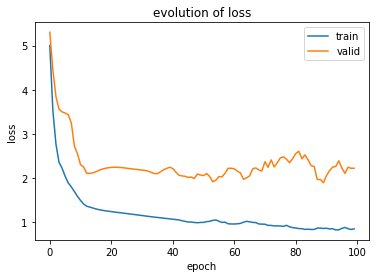

In [11]:
# summarize learning history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('evolution of loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# Analyse the results

In [12]:
# compute predictions and errors
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# train data
y_train_true = y_train_np.squeeze().T
y_train_pred = np.squeeze(model.predict(x_train)).T
print("Train data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_train_true, y_train_pred),
                                                  mean_absolute_percentage_error(y_train_true, y_train_pred)))

# valid data
y_valid_true = y_valid_np.squeeze().T
y_valid_pred = np.squeeze(model.predict(x_valid)).T
print("Valid data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_valid_true, y_valid_pred),
                                                  mean_absolute_percentage_error(y_valid_true, y_valid_pred)))

# test data
y_test_true = y_test_np.squeeze().T
y_test_pred = np.squeeze(model.predict(x_test)).T
print("Test data: MSE={:.4f} MAPE={:.4f}".format(mean_squared_error(y_test_true, y_test_pred),
                                                 mean_absolute_percentage_error(y_test_true, y_test_pred)))

Train data: MSE=0.0441 MAPE=11.8352
Valid data: MSE=0.0735 MAPE=14.5212
Test data: MSE=0.0878 MAPE=15.7502


## Plot individual 24-hour forecasts

In [13]:
# This function is used to plot results
def plot_predictions(y_true, y_pred, title, xlim=[0, 23], ylim=None):
    plt.figure(figsize=(12,4))
    plt.plot(y_true, color='blue', label='True')
    plt.plot(y_pred, color='red', alpha=0.6, label='Pred')    
    plt.title(title)    
    plt.xlabel('time')
    plt.ylabel('power')
    plt.xlim(xlim)
    plt.ylim(ylim)    
    plt.legend()
    plt.show()

ylim = [target_transformer.data_min_, target_transformer.data_max_]

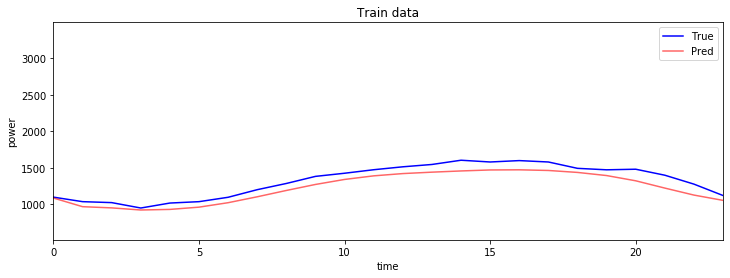

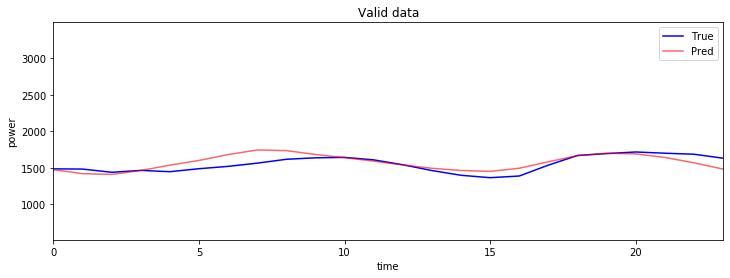

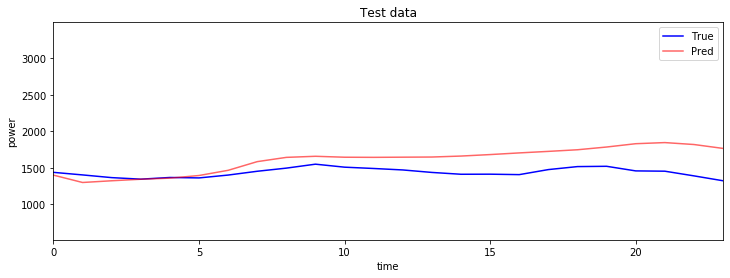

In [14]:
idx = 0 # index of example in a dataset

y_true = target_transformer.inverse_transform( y_train_true[idx,:].reshape(-1, 1) )
y_pred = target_transformer.inverse_transform( y_train_pred[idx,:].reshape(-1, 1) )
plot_predictions(y_true, y_pred, "Train data", ylim=ylim)

y_true = target_transformer.inverse_transform( y_valid_true[idx,:].reshape(-1, 1) )
y_pred = target_transformer.inverse_transform( y_valid_pred[idx,:].reshape(-1, 1) )
plot_predictions(y_true, y_pred, "Valid data", ylim=ylim)

y_true = target_transformer.inverse_transform( y_test_true[idx,:].reshape(-1, 1) )
y_pred = target_transformer.inverse_transform( y_test_pred[idx,:].reshape(-1, 1) )
plot_predictions(y_true, y_pred, "Test data", ylim=ylim)

## Plot all 24-hour forecasts concatenating the results 

In [15]:
# concatenate all true values and all predictions

# true values
y_all_train_true = target_transformer.inverse_transform( y_train_true.flatten().reshape(-1, 1) )
y_all_valid_true = target_transformer.inverse_transform( y_valid_true.flatten().reshape(-1, 1) )
y_all_test_true = target_transformer.inverse_transform( y_test_true.flatten().reshape(-1, 1) )

# predicted values
y_all_train_pred = target_transformer.inverse_transform( y_train_pred.flatten().reshape(-1, 1) )
y_all_valid_pred = target_transformer.inverse_transform( y_valid_pred.flatten().reshape(-1, 1) )
y_all_test_pred = target_transformer.inverse_transform( y_test_pred.flatten().reshape(-1, 1) )

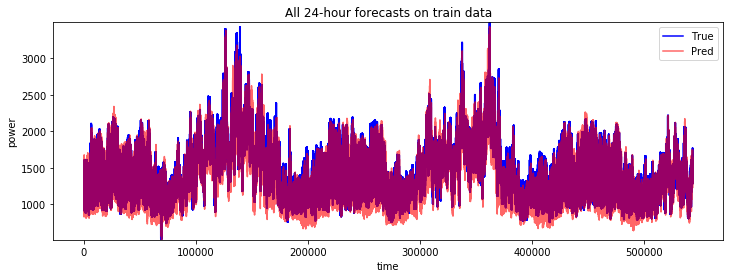

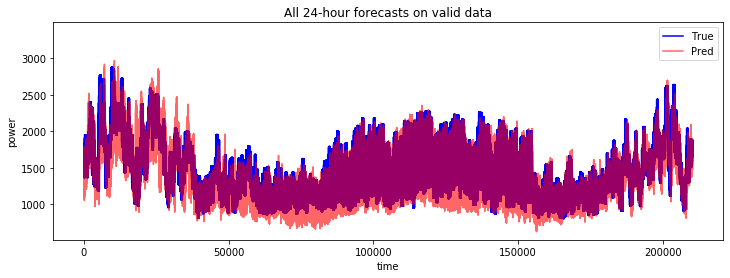

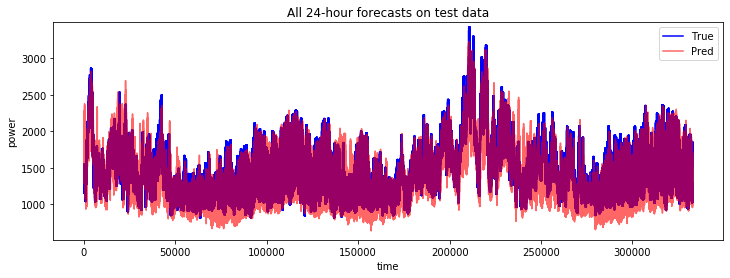

In [16]:
# plot the results
plot_predictions(y_all_train_true, y_all_train_pred, title='All 24-hour forecasts on train data', xlim=None, ylim=ylim)
plot_predictions(y_all_valid_true, y_all_valid_pred, title='All 24-hour forecasts on valid data', xlim=None, ylim=ylim)
plot_predictions(y_all_test_true, y_all_test_pred, title='All 24-hour forecasts on test data', xlim=None, ylim=ylim)


## Plot mean absolute percentage error (MAPE) at different time steps

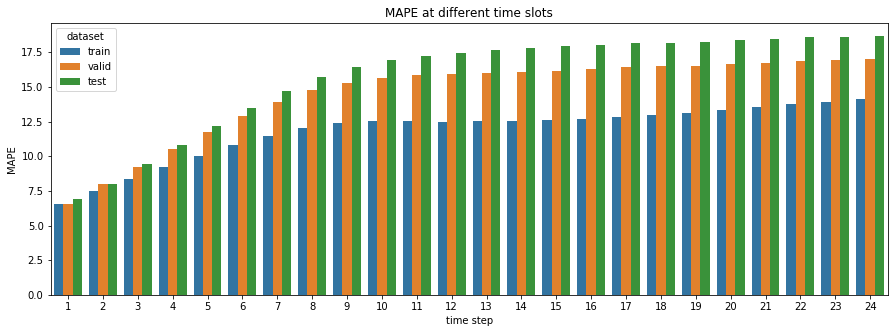

In [17]:
# compute errors
errros_train = [mean_absolute_percentage_error(y_train_true[:,i], y_train_pred[:,i]) for i in range(24)]
errros_valid = [mean_absolute_percentage_error(y_valid_true[:,i], y_valid_pred[:,i]) for i in range(24)]
errros_test = [mean_absolute_percentage_error(y_test_true[:,i], y_test_pred[:,i]) for i in range(24)]

# plot errors
x = list(range(1,25))*3
y = ['train']*24 + ['valid']*24 + ['test']*24
z = errros_train + errros_valid + errros_test
df_mape = pd.DataFrame(data=zip(x, y, z), columns=['time step', 'dataset', 'MAPE'])
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=df_mape, x='time step', hue='dataset', y='MAPE')
ax.set_title('MAPE at different time steps')
plt.show()